## 2D SSN simulation ~  JAX IMPLEMENTATION

Changes required by JAX:
- jax.random vs numpy.random
- introduction of key variables to operate in random **
- np.chararray substituted -> created separate boolean array after locating indices in a list because jax doesnt support character arrays

In [ ]:
#import numpy as np
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
from scipy.linalg import circulant, toeplitz
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
from jax import random

from SSN_classes_jax import SSN2DTopoV1_AMPAGABA

from util import GaborFilter, BW_Grating

## Parameters for network initialisation

In [2]:
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi

# with mm_scale=1, The following match "fixed_params" of  'Fig4_data-retinoHists-samples1000_TauCorr5_2020-04-11.json'
class grid_pars():
    gridsize_Nx = 8 + 1 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141
sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
conn_pars = dict(
    PERIODIC = False,
    J_2x2 = ssn_pars.make_J2x2(*Js0),
    s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]]), # in mm
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000)  # sigma_oris
conn_pars['J_2x2'] = ssn_pars.make_J2x2(*Js0)

## Initialise network

In [3]:
#Create network
ssn = SSN2DTopoV1_AMPAGABA(ssn_pars.n, ssn_pars.k, ssn_pars.tauE,
              ssn_pars.tauI, grid_pars, conn_pars=conn_pars, tau_s=ssn_pars.tau_s)

## Try finding fixed point with input

Input parameters - actual inp not valid (remove add noise 

In [4]:
I2Eexcit = 0;
spont_input = np.array([1,1]) * 3

contrast = 50
grid_pars.sig_ori_EF = 32 # deg (ori)

lcorr_noise_grid = 2.6
rel_sigma_noise = 0.2
sigma_noise = .2 # rel_sigma_noise * contrast
I2E_noise = 2

dt = 1
xtol = 1e-5
Tmax = 200

In [5]:
ssn = SSN2DTopoV1_AMPAGABA(ssn_pars.n, ssn_pars.k, ssn_pars.tauE,
              ssn_pars.tauI, grid_pars, conn_pars=conn_pars, tau_s=ssn_pars.tau_s)

inp0 = contrast * ssn.make_grating_input(radius_s=grid_pars.gridsize_deg * 5, sigma_RF=grid_pars.sigma_RF,
                                sig_ori_EF=grid_pars.sig_ori_EF, gE=gE, gI=gI)

r_init = np.zeros(inp0.shape)

inp = inp0 + np.kron(spont_input +   np.array([1,I2Eexcit]), np.ones(ssn.Ne))

r_fps, CONVG = ssn.fixed_point_r(inp, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)


 Warning 1: reached Tmax=200, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = 0.0006192816072143614,   xtol=1e-05.

Did not reach fixed point.


In [6]:
#Test whether output of input layer can go into SSN

r_fps, CONVG = ssn.fixed_point_r(output_gabor, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
#r_fps2, CONVG2 = ssn.fixed_point_r(r_fps, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)

NameError: name 'output_gabor' is not defined

## Gabor function implementation

Parameters for Gabor filters

In [9]:
#parameters for Gabor filters
edge_length=5.9  #image edge length in degrees
dx_i =1/19.19  #image pixel resolution in degrees (degrees/pixel)
N_pixels=int(edge_length*2/dx_i) +1 # can also specify these directly

#reproduce image axis in degrees
x_axis=np.linspace(-edge_length,edge_length, N_pixels, endpoint=True)  
y_axis=np.linspace(-edge_length,edge_length, N_pixels, endpoint=True)

#sigma_g= edge_length/8 #degree #0.5 - 1degree
sigma_g= 0.5
k= np.pi/(6*sigma_g) #cycles per degree

Iterate over neurons in SSN map

In [10]:
#create empty arrays
all_gabors=[] #array of Gabor classes
e_filters=[] #array of filters

#iterate over SSN map
for i in range(ssn.ori_map.shape[0]):
    for j in range(ssn.ori_map.shape[1]):
        gabor=GaborFilter(x_i=ssn.x_map[i,j], y_i=ssn.y_map[i,j], k=k, sigma_g=sigma_g, theta=ssn.ori_map[i,j], conv_factor=grid_pars.magnif_factor, x_axis=x_axis, y_axis=y_axis, dx=dx_i, dy=dx_i)
        
        e_filters.append(gabor.filter.ravel())
e_filters=np.array(e_filters)

In [11]:
def crop(cf, image):
    image=image[cf:-cf, cf:-cf]
    return image

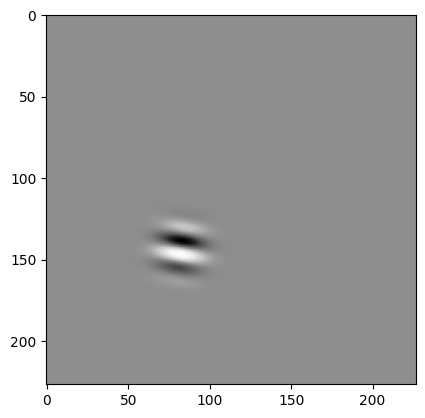

In [12]:
#plot example filter
plt.imshow(e_filters[0].reshape(N_pixels, N_pixels), cmap='Greys')

Create inhibitory Gabor filters

In [13]:
i_constant= 1
i_filters=np.multiply(i_constant, e_filters)
all_filters=np.vstack([e_filters, i_filters]) #shape - (n_neurons, n_pixels in image(n_pixels_x_axis*n_pixels_y_axis))

## Jia stimuli

Import stimuli. Parameters to specify:
- orientation -  in degrees from vertical (anti clockwise) - HAD TO ROTATE CREATION OF GABOR FILTERS!
- size - in pixels 227*227
- outer radius + inner radius
- pixels per degree
- grating contrast - up to 1 (*100 in SSN code)
- snr - 0<= snr <= 1
- phase - in degrees
- spatial frequency - in 1/pixels (need to multiply k* dx_i - dx_i in degrees/pixel)

In [14]:
#Stimulus parameters
ori_deg=90
size=N_pixels #227
phase = 0 #uses random
outer_radius = 3
inner_radius = 2.5
pixel_per_degree=1/dx_i #19.19
grating_contrast = 0.99

In [20]:
test_grating=BW_Grating(ori_deg=ori_deg, size=size, outer_radius=outer_radius, inner_radius=inner_radius, pixel_per_degree=pixel_per_degree, grating_contrast=grating_contrast, snr=1, phase=phase, spatial_frequency=k*dx_i)
test_stimuli=test_grating.BW_image()#shape - (n_pixels in image(n_pixels_x_axis*n_pixels_y_axis, 1)

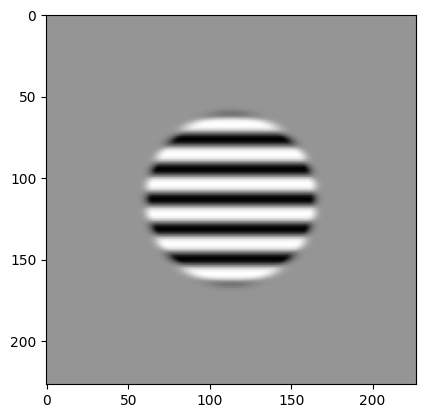

In [22]:
plt.imshow(test_stimuli, cmap='Greys')

### Apply filters to stimulus

Multiply flattened filters by flattened image

In [ ]:
#multiply filters my image
output_gabor=np.matmul(all_filters, test_stimuli.ravel())*A 

#check maximum response is obtained at orientation of stimulus
ssn.ori_map.ravel()[np.argmax(output_gabor)]

### --->Finding average value of constant A over different Gabor filters

1. Select list of indices 

In [23]:
#OPTION 1 - choose random values for the orientation 
key = random.PRNGKey(90)
random_nums=random.choice(key, a=ssn.ori_map)
#indices=random_nums

#OPTION 2 - select angles in spread out range - selects every given number of angles
indices=np.sort(ssn.ori_map.ravel())

2. Run loop for different orientations

In [24]:
#loop over different orientations to find average constant
A=0

gabor_pars = dict(k=2.3, sigma_g=5, ori=20 )
#gabor_pars[:]
all_A=[]
all_gabors=[]
all_test_stimuli=[]

for ori in indices:
    
    #generate Gabor filter and stimuli at orientation
    gabor=GaborFilter(x_i=0, y_i=0, k=k, sigma_g=sigma_g, theta=ori, conv_factor=grid_pars.magnif_factor, x_axis=x_axis, y_axis=y_axis, dx=dx_i, dy=dx_i)
    test_grating=BW_Grating(ori_deg=ori, size=N_pixels, outer_radius=10, inner_radius=10, pixel_per_degree=1/dx_i, grating_contrast=0.9, snr=1, phase=0, spatial_frequency=k*dx_i)
    test_stimuli=test_grating.BW_image()
    
    #multiply filter and stimuli
    output_gabor=np.matmul(gabor.filter.ravel(), test_stimuli.ravel())
    
    all_gabors.append(gabor.filter)
    all_test_stimuli.append(test_stimuli)
    
    
    #calculate value of A
    A_value=100/(output_gabor) 
    
    #create list of A
    all_A.append(A_value)
    
    

#find average value of A
all_A=np.array(all_A)
A=all_A.mean()
all_gabors=np.array(all_gabors)
all_test_stimuli=np.array(all_test_stimuli)

print('Average A is {}'.format(A))

Average A is 0.00099440838675946


3. Test previous loop

In [25]:
test_index = 35
indices[test_index]

DeviceArray(90.771965, dtype=float32)

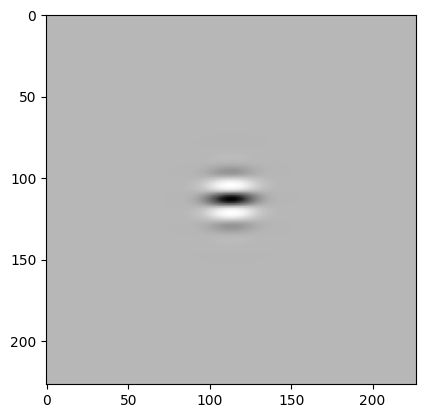

In [26]:
plt.imshow(all_gabors[test_index], cmap='Greys')

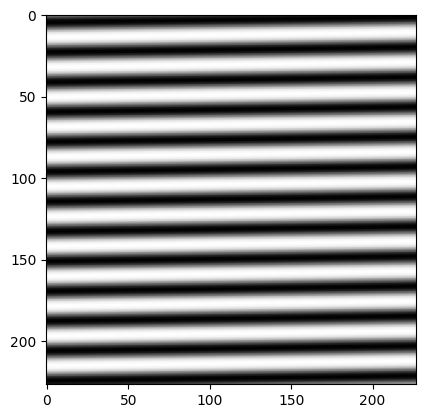

In [27]:
plt.imshow(all_test_stimuli[test_index], cmap='Greys')

In [28]:
#check average value 
output_test=0
for i in range (len(all_gabors)):
    output_test+=np.matmul(all_gabors[i].ravel(), all_test_stimuli[i].ravel())*A
print(output_test/len(all_gabors))

100.00004
